#  How to create a Custom Object Detector using GluonCV and deploy it to Panorama

**About this Notebook** :

* Fine-tuning is commonly used approach to transfer previously trained model to a new dataset.
* It is especially useful if the targeting new dataset is relatively small.
* Finetuning from pre-trained models can help reduce the risk of overfitting.
* Finetuned model may also generalize better if the previously used dataset is in the similar domain of the new dataset.
* This tutorial opens up a good approach for fine-tuning object detection models provided by GluonCV.

**Goal of this Notebook** :

* Aid an Panorama developer in creating a custom Object Detector using GluonCV
* Once the model is created, export the model parameters
* Use the exported parameters to then deploy the model
* Create a sample lambda to loop in the model

**What this Notebook accomplishes?** :

* Show how to use a customized Pikachu dataset and illustrate the finetuning fundamentals step by step.
* Walk thru the steps to modify a model to fit your own object detection projects.
* This is an adaption of the following GluonCV example : [Link](https://gluon-cv.mxnet.io/build/examples_detection/finetune_detection.html)

**Useful Resources to aid your development**:
* [AWS Panorama Documentation](https://docs.aws.amazon.com/panorama/)
* [Create Your Own COCO Dataset](https://gluon-cv.mxnet.io/build/examples_datasets/mscoco.html#sphx-glr-build-examples-datasets-mscoco-py)
* [Create Your Own VOC Dataset](https://gluon-cv.mxnet.io/build/examples_datasets/pascal_voc.html#sphx-glr-build-examples-datasets-pascal-voc-py)
* [sphx-glr-build-examples-datasets-detection-custom](https://gluon-cv.mxnet.io/build/examples_datasets/detection_custom.html#sphx-glr-build-examples-datasets-detection-custom-py)


----------------
### Imports
----------------

In [1]:
%matplotlib inline

In [2]:
import time
import os
from matplotlib import pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon
import gluoncv as gcv
from gluoncv.utils import download, viz
from IPython.display import clear_output, Markdown, display
from ipywidgets import widgets, interact
import boto3
import tarfile
import json
import sagemaker

In [3]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

In [4]:
def printmd(string, color=None):
    """
    Helper Function for Fomatting Output
    """
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

----------------
### Pikachu Dataset
----------------
Starting with a Pikachu dataset generated by rendering 3D models on random real-world scenes.

Please refer to `sphx_glr_build_examples_datasets_detection_custom` link above for tutorial of how to create your own datasets.



In [5]:
url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/train.rec'
idx_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/train.idx'
download(url, path='pikachu_train.rec', overwrite=False)
download(idx_url, path='pikachu_train.idx', overwrite=False)

85605KB [00:01, 48043.85KB/s]                           
12KB [00:00, 4678.10KB/s]             

'pikachu_train.idx'

load dataset using ``RecordFileDetection``



label: [[309.6292  205.79944 355.75494 274.14044   0.     ]]


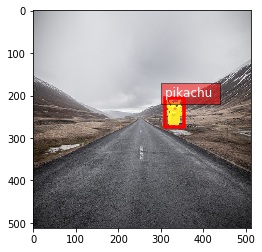

In [6]:
dataset = gcv.data.RecordFileDetection('pikachu_train.rec')
classes = ['pikachu']  # only one foreground class here
image, label = dataset[0]
print('label:', label)
# display image and label
ax = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5], class_names=classes)
plt.show()

----------------
### Pre-trained models
-------------------

Use a pre-trained model to finetune from. There are several choices in the `gluoncv-model-zoo-detection` Model Zoo.
For Demo purpose, a Fast SSD network with MobileNet1.0 backbone is chosen



In [7]:
net = gcv.model_zoo.get_model('ssd_512_mobilenet1.0_voc', pretrained=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/mxnet/gluon/block.py:1389: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


reset network to predict pikachus!



In [8]:
net.reset_class(classes)
# now the output layers that used to map to VOC classes are now reset to distinguish pikachu (and background).

There is a convenient API for creating custom network with pre-trained weights.
This is equivalent to loading pre-trained model and call ``net.reset_class``.




In [9]:
net = gcv.model_zoo.get_model('ssd_512_mobilenet1.0_custom', classes=classes,
    pretrained_base=False, transfer='voc')

--------------------------------------
### Finetuning is a new round of training
--------------------------------------

In [10]:
def get_dataloader(net, train_dataset, data_shape, batch_size, num_workers):
    from gluoncv.data.batchify import Tuple, Stack, Pad
    from gluoncv.data.transforms.presets.ssd import SSDDefaultTrainTransform
    width, height = data_shape, data_shape
    # use fake data to generate fixed anchors for target generation
    with autograd.train_mode():
        _, _, anchors = net(mx.nd.zeros((1, 3, height, width)))
    batchify_fn = Tuple(Stack(), Stack(), Stack())  # stack image, cls_targets, box_targets
    train_loader = gluon.data.DataLoader(
        train_dataset.transform(SSDDefaultTrainTransform(width, height, anchors)),
        batch_size, True, batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)
    return train_loader

train_data = get_dataloader(net, dataset, 512, 16, 0)

Using a GPU for training



In [12]:
try:
    a = mx.nd.zeros((1,))
    ctx = [mx.gpu(0)]
except Exception as e:
    print('Exception is {}'.format(e))
    ctx = [mx.cpu()]

Start training(finetuning)



In [13]:
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(
    net.collect_params(), 'sgd',
    {'learning_rate': 0.001, 'wd': 0.0005, 'momentum': 0.9})

mbox_loss = gcv.loss.SSDMultiBoxLoss()
ce_metric = mx.metric.Loss('CrossEntropy')
smoothl1_metric = mx.metric.Loss('SmoothL1')

for epoch in range(0, 2):
    ce_metric.reset()
    smoothl1_metric.reset()
    tic = time.time()
    btic = time.time()
    net.hybridize(static_alloc=True, static_shape=True)
    for i, batch in enumerate(train_data):
        batch_size = batch[0].shape[0]
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        cls_targets = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        box_targets = gluon.utils.split_and_load(batch[2], ctx_list=ctx, batch_axis=0)
        with autograd.record():
            cls_preds = []
            box_preds = []
            for x in data:
                cls_pred, box_pred, _ = net(x)
                cls_preds.append(cls_pred)
                box_preds.append(box_pred)
            sum_loss, cls_loss, box_loss = mbox_loss(
                cls_preds, box_preds, cls_targets, box_targets)
            autograd.backward(sum_loss)
        # since the loss is already normalized, no more normalization is needed. 
        # by batch-size anymore
        trainer.step(1)
        ce_metric.update(0, [l * batch_size for l in cls_loss])
        smoothl1_metric.update(0, [l * batch_size for l in box_loss])
        name1, loss1 = ce_metric.get()
        name2, loss2 = smoothl1_metric.get()
        if i % 20 == 0:
            print('[Epoch {}][Batch {}], Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}'.format(
                epoch, i, batch_size/(time.time()-btic), name1, loss1, name2, loss2))
        btic = time.time()

[Epoch 0][Batch 0], Speed: 3.077 samples/sec, CrossEntropy=13.332, SmoothL1=2.322
[Epoch 0][Batch 20], Speed: 1.447 samples/sec, CrossEntropy=4.453, SmoothL1=1.402
[Epoch 0][Batch 40], Speed: 1.467 samples/sec, CrossEntropy=3.324, SmoothL1=1.042


Save finetuned weights to disk



In [14]:
net.hybridize()
input_shape = [1,3,512,512]
print('inputs: ', input_shape)
outputs = net(mx.ndarray.zeros(input_shape))
print('outputs: ', [tensor.shape for tensor in outputs])

net.export('ssd_512_mobilenet1.0_pikachu')

inputs:  [1, 3, 512, 512]
outputs:  [(1, 100, 1), (1, 100, 1), (1, 100, 4)]


In [15]:
net.save_parameters('ssd_512_mobilenet1.0_pikachu.params')

----------------------------
### Predict with finetuned model
----------------------------
Test the performance using finetuned weights



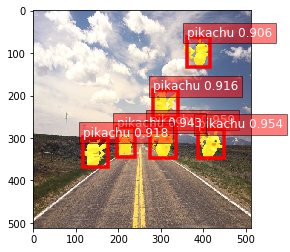

In [16]:
test_url = 'https://raw.githubusercontent.com/zackchase/mxnet-the-straight-dope/master/img/pikachu.jpg'
download(test_url, 'pikachu_test.jpg')

# Name your classes
classes = ['pikachu']

net = gcv.model_zoo.get_model('ssd_512_mobilenet1.0_custom', classes=classes, pretrained_base=False)
net.load_parameters('ssd_512_mobilenet1.0_pikachu.params')
x, image = gcv.data.transforms.presets.ssd.load_test('pikachu_test.jpg', 512)
cid, score, bbox = net(x)
ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=classes)
plt.show()

In two epochs and less than 5 min, pikachus can be detected perfectly!

----------------------------
### Create a tar.gz file with the Model Parameters from above
----------------------------


In [17]:
tar = tarfile.open("ssd_512_mobilenet1.0_pikachu.tar.gz", "w:gz")
for name in ["ssd_512_mobilenet1.0_pikachu-0000.params", "ssd_512_mobilenet1.0_pikachu-symbol.json"]:
    tar.add(name)
tar.close()

----------------------------
### Upload tar.gz file to an S3 bucket
----------------------------

In [ ]:
def send_model_to_s3(model, bucket = 'aws-panorama-models-bucket'):
    s3 = boto3.resource('s3')
    s3.create_bucket(Bucket=bucket)
    
    key = model
    
    s3.Object(bucket, model).put(Body=open(key, 'rb'))
    
    bucket_name = bucket
    
    
    location = boto3.client('s3').get_bucket_location(Bucket='aws-panorama-models-bucket')['LocationConstraint']
    url = "s3://{}/{}".format(bucket_name, model)
    
    printmd("**S3 Path** : **{}**".format(url), color="black")
    
    return

In [ ]:
send_model_to_s3(model = "ssd_512_mobilenet1.0_pikachu.tar.gz")

----------------------------
### Upload, Create and Publish Lambda Function
----------------------------

This Python snippet uses boto3 to create an IAM role named LambdaBasicExecution with basic 
lambda execution permissions.

In [25]:
role_policy_document = {
    "Version": "2012-10-17",
    "Statement":[
        {
            "Effect": "Allow",
            "Principal": {"Service": ["lambda.amazonaws.com", "events.amazonaws.com"]},
            "Action": "sts:AssumeRole",
        }
    ]
}


iam_client = boto3.client("iam")

iam_client.create_role(
    RoleName="LambdaDemoTestExecution_custom_od_demo",
    AssumeRolePolicyDocument=json.dumps(role_policy_document),
)

{'Role': {'Path': '/',
  'RoleName': 'LambdaDemoTestExecution_custom_od_demo',
  'RoleId': 'AROAZAPJMVFPFT6PAE3U7',
  'Arn': 'arn:aws:iam::619501627742:role/LambdaDemoTestExecution_custom_od_demo',
  'CreateDate': datetime.datetime(2020, 9, 2, 21, 28, 2, tzinfo=tzlocal()),
  'AssumeRolePolicyDocument': {'Version': '2012-10-17',
   'Statement': [{'Sid': '',
     'Effect': 'Allow',
     'Principal': {'Service': 'lambda.amazonaws.com'},
     'Action': 'sts:AssumeRole'}]}},
 'ResponseMetadata': {'RequestId': '7d121aaf-ea51-4545-9661-23d96e729f75',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '7d121aaf-ea51-4545-9661-23d96e729f75',
   'content-type': 'text/xml',
   'content-length': '857',
   'date': 'Wed, 02 Sep 2020 21:28:01 GMT'},
  'RetryAttempts': 0}}

The following Python snippet will use the resources above to create a new AWS Lambda function called PikachuDetection_demo

In [26]:
lambda_client = boto3.client("lambda")

with open(
    "PikachuDetection.zip", "rb"
) as f:
    zipped_code = f.read()

role = iam_client.get_role(RoleName="LambdaDemoTestExecution_custom_od")
response_create_function = lambda_client.create_function(
    FunctionName="PikachuDetection_demo",
    Runtime="python2.7",
    Role=role["Role"]["Arn"],
    Handler="PikachuDetection.main()",
    Code=dict(ZipFile=zipped_code),
    Timeout=120,  
    MemorySize=2048,
)

**What is an ARN?** : Amazon Resource Names (ARNs) uniquely identify AWS resources.

The following Python snippet will publish the Lambda Function that was created above, and return an ARN with a version. 

This version arn can be used to go directly to the Panorama console and deploy this application.

In [27]:
response = lambda_client.publish_version(FunctionName="PikachuDetection_demo")

Printing the details of the lambda function that was just published

In [28]:
function_arn = response["FunctionArn"]
function_arn_version = list(response["FunctionArn"].split(":"))[-1]
lambda_url = (
    "https://console.aws.amazon.com/lambda/home?region=us-east-1#/functions/"
    + response["FunctionName"]
    + "/versions/"
    + response["Version"]
    + "?tab=configuration"
)

----------------------------
### Next steps
----------------------------

The Lambda is now created and published. You are now ready to deploy your model and the published lambda function, to the Panorama device

The instructions to deploy are linked below

[Creating Application Instructions Here](https://docs.aws.amazon.com/panorama/)

##### Some helpful information about the Lambda

In [29]:
printmd("**Function Arn** : **{}**".format(function_arn), color="black")
printmd("**Function Arn Version** : **{}**".format(function_arn_version), color="black")
printmd("**Lambda Console Link** : **{}**".format(lambda_url), color="black")

<span style='color:black'>**Function Arn** : **arn:aws:lambda:us-east-1:619501627742:function:PikachuDetection_demo:1**</span>

<span style='color:black'>**Function Arn Version** : **1**</span>

<span style='color:black'>**Lambda Console Link** : **https://console.aws.amazon.com/lambda/home?region=us-east-1#/functions/PikachuDetection_demo/versions/1?tab=configuration**</span>

##### Some helpful information about the Model

In [36]:
path = '{}'.format('s3://' + bucket_name + '/' + folder_on_bucket + "ssd_512_mobilenet1.0_pikachu.tar.gz")

printmd('**S3 Model Bucket Path is :** {}'.format(path), color="black")

<span style='color:black'>**S3 Model Bucket Path is :** s3://omni-sagemaker-models-surya//mxnet/originalssd_512_mobilenet1.0_pikachu.tar.gz</span>

In [30]:
printmd("**Inputs**", color="black")
print('     ')
printmd("**Input Name** : **{}**".format('data'), color="black")
printmd("**Shape** : **{}**".format(input_shape), color="black")
printmd("**Order** : **{}**".format('NCHW'), color="black")
printmd("**FourCC** : **{}**".format('BGR3'), color="black")
printmd("**Normalize** : **{}**".format('minmax'), color="black")
printmd("**Minmax range** : **{}**".format('[0,255]'), color="black")


<span style='color:black'>**Inputs**</span>

<span style='color:black'>**Input Name** : **data**</span>

<span style='color:black'>**Shape** : **[1, 3, 512, 512]**</span>

<span style='color:black'>**Order** : **NCHW**</span>

<span style='color:black'>**FourCC** : **BGR3**</span>

<span style='color:black'>**Normalize** : **minmax**</span>

<span style='color:black'>**Minmax range** : **[0,255]**</span>

In [31]:
printmd("**Outputs**", color="black")
print('     ')
printmd("**Output0**", color="black")
printmd("**Output Name** : **{}**".format('NMS'), color="black")
printmd("**Shape** : **{}**".format('[1,1,100,1]'), color="black")
print('     ')
printmd("**Output1**", color="black")
printmd("**Output Name** : **{}**".format('NMS1'), color="black")
printmd("**Shape** : **{}**".format('[1,1,100,1]'), color="black")
print('     ')
printmd("**Output2**", color="black")
printmd("**Output Name** : **{}**".format('NMS2'), color="black")
printmd("**Shape** : **{}**".format('[1,1,100,4]'), color="black")



<span style='color:black'>**Outputs**</span>

<span style='color:black'>**Output0**</span>

<span style='color:black'>**Output Name** : **NMS**</span>

<span style='color:black'>**Shape** : **[1,1,100,1]**</span>

<span style='color:black'>**Output1**</span>

<span style='color:black'>**Output Name** : **NMS1**</span>

<span style='color:black'>**Shape** : **[1,1,100,1]**</span>

<span style='color:black'>**Output2**</span>

<span style='color:black'>**Output Name** : **NMS2**</span>

<span style='color:black'>**Shape** : **[1,1,100,4]**</span>